%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import torch, torchvision 
from PIL import Image

In [3]:
df_infos4 = pd.read_csv('../saved/infos4.csv')

In [4]:
import pickle
with open('../saved/data_imgs2.pkl', 'rb') as f:
    data_imgs2 = pickle.load(f)

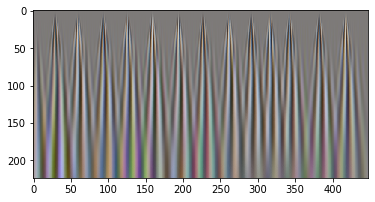

In [5]:
plt.imshow(data_imgs2[5][3])

In [6]:
n_segments = 5
def crop_imgs(data_img, n_segments = n_segments, vis = False):
    
    shift_len = int((data_img[0].size[0]-224) / (n_segments-1))
    if vis:
        plt.imshow(data_img)
        plt.show()
        
    # each imgs
    imgs = []
    for i in range(n_segments):
        
        # each channel of each segment
        img_chns = []
        for chn in range(4):
            img = data_img[chn].crop((i*shift_len,0,i*shift_len+224,224)) # 0, 0, 224, 224 left, upper, right, and lower
            img_chns.append(img)
            
            if vis:
                plt.imshow(img)
                plt.show()
                
        imgs.append(img_chns)
    return imgs

data_img2_crops = []
for i in tqdm(range(len(data_imgs2))):
    data_img2_crops += crop_imgs(data_imgs2[i])
    

In [7]:
from torch.utils.data import Dataset
from torchvision import transforms
from global_vars import labels
import os
class MyImageMultichannelBag(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, infos, n_segments, channel_imgs):
        """
                
        channel_imgs = chn -> array of PImage
        """
        self.infos = infos
        self.channel_imgs = channel_imgs
        self.n_segments = n_segments
        self.transform =  transforms.Compose([
                         transforms.ToTensor(),
                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         ])

    def __len__(self):
        return len(self.infos)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        image_bags = []
        for i in range(n_segments):
            images = [self.channel_imgs[idx+i][chn] for chn in range(4)]
            image_bags.append(images)
        info_labels = self.infos.iloc[idx][labels]
        sample =([torch.cat([self.transform(image) for image in images],0) for i in range(n_segments)], 
                  torch.Tensor(info_labels.astype(int))) # a bag has n_segments items

        return sample
    
image_datasets = MyImageMultichannelBag(df_infos4, n_segments, data_img2_crops)

In [8]:
imgs0, label0 = image_datasets[0]


In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [10]:
from torch import nn
from torchvision import models
import torch.nn.functional as F
    
class MultiCWTNet(nn.Module):
    def __init__(self, device, verbose=False):
        super(MultiCWTNet, self).__init__()
        
        self.resnet = models.resnet50(pretrained=True)
        self.resnet.conv1 = self.increase_channels(self.resnet.conv1, num_channels=12, copy_weights=0)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, 9)
        self.resnet.to(device)
        self.relu = nn.ReLU(inplace=True)
        self.verbose = verbose
        #self.sigmoid = nn.Sigmoid()
        
    def forward(self, xs):
        x = self.resnet(xs)
        x = self.relu(x)
        #x = self.sigmoid(x)
        return x
    
    
    def increase_channels(self, m, num_channels=None, copy_weights=0):
        """
        https://github.com/akashpalrecha/Resnet-multichannel/blob/master/multichannel_resnet.py
        
        takes as input a Conv2d layer and returns the a Conv2d layer with `num_channels` input channels
        and all the previous weights copied into the new layer.
        
        copy_weights (int): copy the weights of the channel (int)
        """
        # number of input channels the new module should have
        new_in_channels = num_channels if num_channels is not None else m.in_channels + 1
        
        # Creating new Conv2d layer
        new_m = nn.Conv2d(in_channels=new_in_channels, 
                          out_channels=m.out_channels, 
                          kernel_size=m.kernel_size, 
                          stride=m.stride, 
                          padding=m.padding,
                          bias=False)
        
        # Copying the weights from the old to the new layer
        new_m.weight[:, :m.in_channels, :, :] = m.weight.clone()
        
        #Copying the weights of the `copy_weights` channel of the old layer to the extra channels of the new layer
        for i in range(new_in_channels - m.in_channels): # 12 - 3
            channel = m.in_channels + i # 3，4，5，6，7，8，9，10，11
            new_m.weight[:, channel:channel+1, :, :] = m.weight[:, copy_weights:copy_weights+1, : :].clone()
        new_m.weight = nn.Parameter(new_m.weight)

        return new_m

In [11]:
def geometry_loss(fbeta, gbeta):
    return np.sqrt(fbeta*gbeta)

#geometry_loss(fbeta2, gbeta2)

In [12]:
def weighted_binary_cross_entropy(x, y, pos_weight, weight=None, reduction=None):
    """
    Args:
        sigmoid_x: predicted probability of size [N,C], N sample and C Class. Eg. Must be in range of [0,1]
        targets: true value, one-hot-like vector of size [N,C]
        pos_weight: Weight for postive sample
    """
    if not (y.size() == x.size()):
        raise ValueError("Target size ({}) must be the same as input size ({})".format(targets.size(), x.size()))
   
    x = torch.clamp(x,min=1e-7,max=1-1e-7) 
    #loss = - (pos_weight*y*x.log() + (1-y)*(1-x).log())
    loss = - (pos_weight*y*x.log() + (1-y)*(1-x).log())
    if weight is not None:
        loss = loss * weight
    loss = loss.sum(axis=1)

    if reduction is None:
        return loss
    elif reduction == 'mean':
        return loss.mean()
    elif reduction == 'sum':
        return loss.sum()
    return None
    
class WeightedBCELoss(nn.Module):
    def __init__(self, pos_weight, weight=None, PosWeightIsDynamic= False, WeightIsDynamic= False, 
                 reduction='mean'):
        """
        Args:
            pos_weight = Weight for postive samples. Size [1,C]
            weight = Weight for Each class. Size [1,C]
            PosWeightIsDynamic: If True, the pos_weight is computed on each batch. If pos_weight is None, then it remains None.
            WeightIsDynamic: If True, the weight is computed on each batch. If weight is None, then it remains None.
        """
        super().__init__()

        self.register_buffer('weight', weight)
        self.register_buffer('pos_weight', pos_weight)
        self.reduction = reduction
        self.PosWeightIsDynamic = PosWeightIsDynamic

    def forward(self, input, target):
        # pos_weight = Variable(self.pos_weight) if not isinstance(self.pos_weight, Variable) else self.pos_weight
        if self.PosWeightIsDynamic:
            positive_counts = target.sum(dim=0)
            nBatch = len(target)
            self.pos_weight = (nBatch - positive_counts)/(positive_counts +1e-5)


        return weighted_binary_cross_entropy(input, target,
                                             self.pos_weight,
                                             weight=self.weight,
                                             reduction=self.reduction)


In [21]:
from torchvision import datasets, models, transforms
from myeval import binary_acc
import torch.optim as optim
from torch.optim import lr_scheduler
from snippets.pytorchtools import EarlyStopping
from sklearn.model_selection import GroupKFold
import time

st = time.time()
patience = 20
kf = GroupKFold(5)
batch_size=14

saved_dir = '../saved/modelMultiCWTFullBag/'
y = df_infos4[labels].astype(int)
lambda_const = 1 #torch.Tensor(0.0001).to(device)

for i, (train_idx, test_idx) in enumerate(kf.split(df_infos4, y, df_infos4['ptID'])):
    
    trainDataset = torch.utils.data.Subset(image_datasets, train_idx)
    testDataset = torch.utils.data.Subset(image_datasets, test_idx)
    
    trainLoader = torch.utils.data.DataLoader(trainDataset, batch_size=batch_size, shuffle = True, pin_memory=True)#sampler = sampler)
    testLoader = torch.utils.data.DataLoader(testDataset, batch_size = batch_size, shuffle = False, pin_memory=True)

    model = MultiCWTNet(device, verbose=False)
    model.to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9) #
    # Decay LR by a factor of 0.1 every 100 epochs
    scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    
    pos_weight = np.ones(9) * 2
    pos_weight = torch.Tensor(pos_weight).to(device)
    
    df_y_train = df_infos4.iloc[train_idx][labels].to_numpy().astype(int)
    class_weights = 1.0/np.sum(df_y_train,axis=0)
    class_weights = class_weights / np.sum(class_weights)
    class_weights = torch.Tensor(class_weights).to(device)
    #criterion_train = nn.BCELoss() #
    criterion_train = WeightedBCELoss(pos_weight=pos_weight, weight=class_weights, reduction='sum') #
    
    df_y_test = df_infos4.iloc[test_idx][labels].to_numpy().astype(int)
    class_weights_test = 1.0/np.sum(df_y_test,axis=0)
    class_weights_test = class_weights_test / np.sum(class_weights_test)
    class_weights_test = torch.Tensor(class_weights_test).to(device)    
    #criterion_test = nn.BCELoss() #
    criterion_test = WeightedBCELoss(pos_weight=pos_weight, weight=class_weights_test, reduction='sum') #, 

    losses_train = []
    losses_test = []

    avg_losses_train = []
    avg_losses_test = []


    early_stopping = EarlyStopping(patience, verbose=False, 
                                  saved_dir=saved_dir, 
                                   save_name='MutliCWTNetFull'+str(i))
    epoch = 0
    auroc = 0
    auprc = 0
    accuracy = 0
    fmeasure = 0
    fbeta = 0
    gbeta = 0
    for epoch in range(1000):
        
        model.train()
        y_train_preds = []
        y_trains = []
        for X_train, y_train in tqdm(trainLoader):
            y_train = y_train.to(device)
            optimizer.zero_grad()
            
            # for each item in the bag
            output_train_items = []
            y_train_pred_items = []
            for X_train_item in X_train:
                X_train_item = X_train_item.to(device)
                output_train_item = model(X_train_item)
                output_train_items.append(output_train_item)
                y_train_pred_item = torch.exp(output_train_item * (-lambda_const)) # (10) p(1|xj)=1-exp(-hj) from 0.0 to 1.0
                y_train_pred_items.append(y_train_pred_item) 
            
            
            # calculate the output
            output_train_sum = torch.sum(torch.stack(output_train_items), dim=0)
            output_train = torch.exp(output_train_sum * (-lambda_const))# (12)
            
            # calculate the y_pred
            y_train_pred_0 = torch.prod(torch.stack(y_train_pred_items), dim=0) #p(0|B) = prod(1-p(1|xj))
            y_train_pred = torch.ones(y_train_pred_0.shape).to(device)- y_train_pred_0 # (9) 1-p(0|B)

            loss_train = criterion_train(output_train, y_train)
            losses_train.append(loss_train.item())
            loss_train.backward()
            optimizer.step()
            
            y_train_preds.append(y_train_pred.cpu())
            y_trains.append(y_train.cpu())

        scheduler.step()
        
        avg_loss_train = np.average(losses_train)
        avg_losses_train.append(avg_loss_train)
        
        y_test_preds = []
        y_tests = []
        with torch.no_grad():
            model.eval()
            
            for X_test, y_test in testLoader:  
                y_test = y_test.to(device)
                optimizer.zero_grad()
                output_train_items = []
                
                # for each item in the bag
                output_test_items = []
                y_test_pred_items = []
                for X_test_item in X_test:
                    X_test_item = X_test_item.to(device)
                    output_test_item = model(X_test_item)
                    #print(output_test_item)
                    output_test_items.append(output_test_item)
                    y_test_pred_item = torch.exp(output_test_item * (-lambda_const)) # (10) p(1|xj)=1-exp(-hj)
                    y_test_pred_items.append(y_test_pred_item)

                # calculate the output
                output_test_sum = torch.sum(torch.stack(output_test_items), dim=0)
                output_test = torch.exp(output_test_sum * (-lambda_const))# (12)

                # calculate the y_pred
                y_test_pred_0 = torch.prod(torch.stack(y_test_pred_items), dim=0) # p(0|B) = prod(1-p(1|xj))
                y_test_pred = torch.ones(y_test_pred_0.shape).to(device)- y_test_pred_0 # (9) 1-p(0|B)
            
                loss_test = criterion_test(output_test, y_test)
                losses_test.append(loss_test.item())
                
                y_test_preds.append(y_test_pred.cpu())
                y_tests.append(y_test.cpu())
                
            avg_loss_test = np.average(losses_test)
            avg_losses_test.append(avg_loss_test)

        
        y_train_preds = torch.cat(y_train_preds, axis=0)
        y_trains = torch.cat(y_trains, axis=0)
        acc, fmeasure, fbeta, gbeta, auroc, auprc = binary_acc(y_train_preds, y_trains)

        y_test_preds = torch.cat(y_test_preds, axis=0)
        y_tests = torch.cat(y_tests, axis=0)
        acc2, fmeasure2, fbeta2, gbeta2, auroc2, auprc2 = binary_acc(y_test_preds, y_tests)
        
        geometry = geometry_loss(fbeta, gbeta)
        geometry2 = geometry_loss(fbeta2, gbeta2)
        output_str = 'S{}/{} {:.2f} min|\nTrain Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, auroc: {:.3f}, auprc: {:.3f}, geo: {:.3f} |\nValid Loss: {:.6f}, Acc: {:.3f}, F: {:.3f}, Fbeta: {:.3f}, gbeta: {:.3f}, auroc: {:.3f}, auprc: {:.3f}, geo: {:.3f}\n '.format(
            i, epoch, (time.time()-st)/60,
            avg_loss_train, acc, fmeasure, fbeta, gbeta, auroc, auprc, geometry,
            avg_loss_test, acc2, fmeasure2, fbeta2, gbeta2, auroc2, auprc2, geometry2)
        print(output_str)
        
        with open(saved_dir+'loss{}.txt'.format(i), 'a') as f:
            print(output_str, file=f)
            
        
        early_stopping(-geometry2, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    output_string = 'AUROC|AUPRC|Accuracy|F-measure|Fbeta-measure|Gbeta-measure|Geomotry\n{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}|{:.3f}'.format(auroc2,auprc2,acc2,fmeasure2,fbeta2,gbeta2,geometry_loss2)
    print(output_string)     
    with open(saved_dir+'score'+ str(i)+ '_epoch' + str(epoch) + '.txt', 'w') as f:
        f.write(output_string)

    avg_losses_train = np.array(avg_losses_train)
    avg_losses_test = np.array(avg_losses_test)
    
    np.save(saved_dir + 'avg_losses_train' + str(i) + '_epoch' + str(epoch), avg_losses_train)
    np.save(saved_dir + 'avg_losses_test' + str(i) + '_epoch' + str(epoch), avg_losses_test)
    


S0/0 7.48 min|
Train Loss: 103.134072, Acc: 0.426, F: 0.204, Fbeta: 0.113, gbeta: 0.060, auroc: 0.500, auprc: 0.373, geo: 0.082 |
Valid Loss: 56.290873, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.079
 



S0/1 14.71 min|
Train Loss: 80.183497, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.080 |
Valid Loss: 56.290873, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.079
 



S0/2 21.96 min|
Train Loss: 72.533305, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.080 |
Valid Loss: 56.290873, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.079
 



S0/3 29.28 min|
Train Loss: 68.708209, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.080 |
Valid Loss: 56.290873, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.079
 



S0/4 36.85 min|
Train Loss: 66.413151, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.080 |
Valid Loss: 56.290873, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.079
 



S0/5 44.42 min|
Train Loss: 64.883113, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.080 |
Valid Loss: 56.290873, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.079
 



S0/6 51.69 min|
Train Loss: 63.790228, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.080 |
Valid Loss: 56.290873, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.079
 



S0/7 58.96 min|
Train Loss: 62.970565, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.080 |
Valid Loss: 56.290873, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.079
 



S0/8 66.45 min|
Train Loss: 62.333049, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.080 |
Valid Loss: 56.290873, Acc: 0.333, F: 0.209, Fbeta: 0.107, gbeta: 0.059, auroc: 0.500, auprc: 0.559, geo: 0.079
 


KeyboardInterrupt: 

In [ ]:
criterion_train = WeightedBCELoss(weight=class_weights, reduction='sum')
criterion_train(output_train, y_train)
output_train.shape

In [ ]:
output_train = torch.Tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9],
                             [1, 1, 1, 1, 1, 1, 1, 1, 1],
                            ]).to(device)

In [ ]:
class_weights.shape

In [ ]:
class_weights

In [ ]:
loss = class_weights*output_train # posweight*output_train

In [ ]:
loss.sum(axis=1)

In [ ]:
output_train_item = model(X_train_item)

In [ ]:
output_train

In [ ]:
t4 = torch.randn(3, 3).to(device)
print(t3)

In [ ]:
output_train = torch.sum(torch.stack(output_train_items, dim=0), dim=0)